<a href="https://colab.research.google.com/github/gmedina-v/discriminative-vs-generative-classification/blob/main/generative_vs_discriminative_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative vs Discriminative models. An illustrated example in text classification

There are two main approaches to classification in machine learning, discriminative models and generative models. Loosely speaking, the former focuses on modeling the decision boundary between classes, while the latter, on modeling the classes themselves. There are plenty of resources online explaining in detail the differences between them  (see, for example, [[1](https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf), [2](https://stackoverflow.com/questions/879432/what-is-the-difference-between-a-generative-and-a-discriminative-algorithm), [3](https://towardsdatascience.com/generative-vs-2528de43a836), [4](https://stats.stackexchange.com/questions/12421/generative-vs-discriminative)]). However, the question still remains a hot topic among machine learning newcomers as of today.

This notebook presents an illustrative example of the difference between discriminative and generative models in a text classification task using simple linear classifiers. Hopefully, this can shed some light on what it is exactly that the two categories of models are doing differently. I find that this example is especially illuminating since reading and classifying a text is something we are all familiar with. Moreover, the exercise is quite simple and the code is straightforward to follow.

The task is to classify documents in the appropriate category. The documents in question are abstracts from scientific articles published on the [arXiv](https://arxiv.org). Since an article may correspond to multiple categories, this is a multi-label classification task. For instance, a paper could concern both theoretical physics and general relativity (see cross-lists). The abstracts and categories are found in the [arXiv metedata dataset](https://kaggle.com/Cornell-University/arXiv) hosted in Kaggle. These can be downloaded from the website or using the Kaggle API.

The outline of the notebook is as follows. The first section consists of loading the dataset and a brief data exploratory analysis to understand the problem. The second section constructs the set of features that will be used to train the models. In the the third section, the linear classifiers are introduced and trained. The fourth section provides a comparative analysis by inspecting the most and least informative features that the models have learnt. Finally, the fifth section provides a recap and the conclusions.

## Contents:
1. Loading the data and exploratory data analysis
2. Constructing features
3. Fitting the classifiers
4. Comparative analysis: discriminative vs. generative models
5. Conclusions

## 1. Loading the data and exploratory data analysis

The data set can be obtained using the Kaggle API. To do this, we must first upload our API token to the environment and put it in the appropriate folder. If you don't know how to use the API how generate a token, see [this link](https://github.com/Kaggle/kaggle-api)

In [1]:
from google.colab import files
files.upload();
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Now we can download the dataset with the following command

In [2]:
!kaggle datasets download -d 'Cornell-University/arxiv'

 99% 896M/906M [00:15<00:00, 66.9MB/s]
100% 906M/906M [00:15<00:00, 60.4MB/s]


Unzip the file to access the contents

In [3]:
import zipfile
with zipfile.ZipFile('/content/arxiv.zip','r') as file:
  file.extractall('/content/')

The following modules will be useful for processing the dataset

In [4]:
import json
import re
import string
import textwrap
import itertools
import numpy as np

Papers in the arXiv are catalogued in a variety of broad categories. Some of these, in turn, may be subdivided into more specific categories. In this exercise, we will only consider classification on the broad categories. These can be inferred from looking at the categories on arxiv.org, or by going through the first few thousand observations in the data set. We might as well capture the abstracts since we're iterating over the dataset already in the following cell.

In [5]:
path_dataset = '/content/arxiv-metadata-oai-snapshot.json'
# Construct a generator to read the observations in the json file one by one
gen_json = (json.loads(line) for line in itertools.islice(open(path_dataset,'r'),5000))
# Take the 'categories' field of each record, split it by blank spaces to obtain the list of categories the record belongs to.
# Then split each category name by a dot '.' and keep only the first part describing the broad category name.
temp_labels = [elem.split('.')[0] for line in [line['categories'].split() for line in gen_json] for elem in line]
temp_abs = [line['abstract'] for line in gen_json]
# Sort the set of unique categories, record the number of categories (19) and display what these are 
categories = list(sorted(set(temp_labels)))
num_cat = len(categories)
print(f'There are {num_cat} categories, these are the following:')
print(categories)

There are 19 categories, these are the following:
['astro-ph', 'cond-mat', 'cs', 'econ', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math', 'math-ph', 'nlin', 'nucl-ex', 'nucl-th', 'physics', 'q-bio', 'q-fin', 'quant-ph', 'stat']




To understand the types of documents in the data set and what special cases we may encounter in the data, you should go through a few examples. The abstracts were saved in 'temp_abs' in the previous cell, you can print a few of them. In particular, it is instructive to look at the abstracts in indices 0, 2, 5, 19 and 138. For these examples, we can notice the following characteristics:

* Newline characters are included within the text to serve as text wrap for aesthetic purposes. These can break sentences and even words.
* There may be numbers with positive or negative signs, percentage signs and exponents.
* There may be physical units, such as m/s^2 (meters over seconds squared).
* Mathematical formulas are mostly expressed using latex in-line math notation, enclosed by \$...\$.
* However, formulas may sometimes be written as raw text.
* Abstracts may include proper nouns following scientific nomenclature, such as 'NGC6752'.

It will be useful to standardise all these special cases to reduce the vocabulary in the data. For example, x = 2 and y = 3 are both examples of mathematical formulas and can be replaced by a single token. Tokens are the units that the text will be parsed into. Similarly, it is unlikely that a particular number would be more predictive than other, therefore, all ocurrences of numbers can be replaced by a single token as well. Based on this, we define a few rules to standardise the text. Additionally, in rare occasions a character may have become corrupted at some point during encoding. We can add special rules to treat these cases, however, if we stick to only the first 20k examples in the data set this should not be an issue.

The following cell reads the first (num_examples) abstracts and performs some transformations to standardise the text. The labels are encoding using a one-hot representation.


In [6]:
# Number of observations to load
num_examples = 10000
gen_json = (json.loads(line) for line in itertools.islice(open(path_dataset,'r'),num_examples))
# Initialise an empty list to store the abstracts and an array of zeros to store the labels
# The labels will be stored using one-hot encoding, thus, we know the exact dimensions of the array
abstracts = []
labels = np.zeros((num_examples,num_cat))
for idx, line in enumerate(gen_json):
    # Read abstract, transform to lowercase.
    abs = line['abstract'].lower()
    # Remove newline characters
    abs = re.sub(r'(\S)\n(\S)',r'\1 \2',abs)
    # Fix corrupted characters
    abs = abs.replace('â\x80\x99',"'")
    abs = abs.replace('\x7f',"")
    abs = abs.replace('â\x88\x9e',"'")
    abs = abs.replace('â\x89¤',"'")
    abs = abs.replace('â\x80\x94',"'")
    abs = abs.replace('â\x80\x93',"-")
    # Replace latex in-line math expressions $...$ with 'xmathx'
    abs = re.sub(r'\$.+?\$','xmathx',abs)
    # Replace any number that may contain a sign and a decimal part with 'xnumx'
    abs = re.sub(r'-*\+*\d+\.*\d*%*','xnumx',abs)
    # Matches operations between numbers expressed by a single character, such as * - + ^ /
    abs = re.sub(r'\(*xnumx\)*(\s*\S{1}\s*\(*xnumx\)*)*','xnumx',abs)
    # Matches physical units to some power, e.g. m^3
    abs = re.sub(r'(\S)*\^(xnumx)',r'xunitx',abs)
    # Matches digits and characters with no whitspace between them, such as 'NGC6752'
    abs = re.sub(r'((xnumx)+[a-z]+)|([a-z]+(xnumx)+)\S*','xalphax',abs)
    # Not all math formulas are enclosed in $...$. Try to catch some of these instances
    # Matches non-whitespace that has an underscore or a caret
    abs = re.sub(r'\S+[_^]\S+','xmathx',abs)
    # Matches non-whitespace that has a double backslash except \'
    abs = re.sub(r'\S*\\[^\\\']\S+','xmathx',abs)
    # Matches two non-whitespaces with a binary comparator operator in the middle 
    # except '-' with optional whitespace
    abs = re.sub(r'\S+\s*([=+><]|>=|=>|<=|=<|=)\s*\S+','xmathx',abs)
    # Matches two math formulas with a '-' in the middle, i.e. xmathx-xmathx
    # It does not match hyphenated text
    abs = re.sub(r'xmathx\s*-\s*xmathx','xmathx',abs)
    # Add standardised abstract to the list
    abstracts.append(abs)
    # Read list of categories of the current observation
    cat = line['categories'].split()
    # Record labels using one-hot encoding
    for elem in cat:
        labels[idx,categories.index(elem.split('.')[0])] = 1

Verify the dimensions of the abstract list and labels array

In [7]:
print(len(abstracts))
print(labels.shape)

10000
(10000, 19)


Let's take a look at the distribution of labels in the data set. We will briefly use pandas to do this.

In [8]:
import pandas as pd
df_labels = pd.DataFrame(labels,columns=categories)

Most examples in the sample belong to three categories, 'math', 'astro-ph' and 'cond-mat', while very few correspond to 'econ' and 'q-fin'.

,count,proportion (%)
astro-ph,2069.0,16.320896
cond-mat,1926.0,15.192869
cs,521.0,4.109805
econ,2.0,0.015777
gr-qc,558.0,4.401672
hep-ex,224.0,1.766980
hep-lat,99.0,0.780942
hep-ph,901.0,7.107360
hep-th,996.0,7.856748
math,2495.0,19.681313


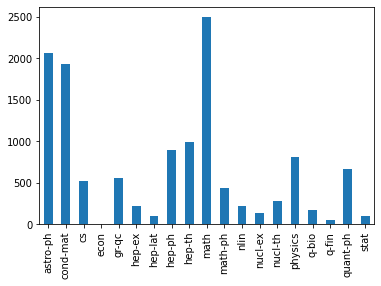

In [9]:
df_labels.agg('sum',axis=0).plot(kind='bar');
total_counts = df_labels.agg('sum',axis=0)
total_counts = pd.concat([total_counts,total_counts/total_counts.sum()*100],axis=1)
total_counts.columns = ['count','proportion (%)']
total_counts

Evidently, the classes are largely unbalanced. Thus, if we train the same classifier to predict all classes, we can expect that it will perform much better on the classes with the largest volume. Note that since this is a multi-label classification task, the sum of the the counts reported in the table above is larger than the number of observations.

## 2. Constructing features

Next we need to tokenise the text. We will use the *nltk* module to accomplish this. This means that the text is separated into units that we can use for training a classifier. Tokens are typically words, but depending on the application, they could also be sub-words, sentences or even paragraphs. In this case, word tokenisation is more suitable.

Moreover, we will be using a bag of words approach, i.e. we assume that the order of the words does not matter. This is a very rough approximation, however it allows for great simplicity and you will see that the results are not too bad. Thus, we should filter out useless words such as stop word, i.e., words so common that they appear everywhere and are not useful for separating the classes. The *nltk* module has a collection of stop words derived from common words in English

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.text import TextCollection
nltk.download('stopwords');
nltk.download('punkt');

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The predefined stop words from *nltk* are the following:

In [11]:
textwrap.wrap(', '.join(stopwords.words('english')),70)

["i, me, my, myself, we, our, ours, ourselves, you, you're, you've,",
 "you'll, you'd, your, yours, yourself, yourselves, he, him, his,",
 "himself, she, she's, her, hers, herself, it, it's, its, itself, they,",
 'them, their, theirs, themselves, what, which, who, whom, this, that,',
 "that'll, these, those, am, is, are, was, were, be, been, being, have,",
 'has, had, having, do, does, did, doing, a, an, the, and, but, if, or,',
 'because, as, until, while, of, at, by, for, with, about, against,',
 'between, into, through, during, before, after, above, below, to, from,',
 'up, down, in, out, on, off, over, under, again, further, then, once,',
 'here, there, when, where, why, how, all, any, both, each, few, more,',
 'most, other, some, such, no, nor, not, only, own, same, so, than, too,',
 "very, s, t, can, will, just, don, don't, should, should've, now, d,",
 "ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn,",
 "didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, 

In addition to common words in the language, we should also search for stop words specific to the corpus we are working with. You can do this by running the tokeniser once and inspecting the most common tokens that do not carry much semantic meaning. Doing this, you can identify that the following tokens should be added to the list of stop words:

In [12]:
add_stopwords = [ 'show','results','also','two','using','study','present',
                  'one','paper','find','new','based',"''","'s",'used']

These words are commonly used in scientific writing. A generic example of an abstract would go something like this:

"In this paper/stuy, we present/show a new [...]. Using the method of/Based on [...], we find [...] . The results (also) show that [...]"

Thus, we tokenise the text removing stopwords and any special or puctuation characters that were not captured by the previous processing rules.

In [13]:
tokenized_abs = [nltk.word_tokenize(abs) for abs in abstracts]
stop_words = set(stopwords.words('english')+add_stopwords)
cl_tkn_abs = [[tkn for tkn in abs if 
                (tkn not in stop_words) and 
                (tkn not in '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~\n')] 
              for abs in tokenized_abs]

In the approach we follow here, the tokens will define the features of the data via the document-term matrix, a matrix where each row is a document (observation) and each column is a token (feature). What the values in this matrix are is up to us. Common choices are to fill the matrix with boolean frequencies, frequency counts, normalised frequency counts and tf-idf (term frequency-inverse document frequency). It will be convenient to save the abstracts in a TextCollection object from the nltk.text module.

In [14]:
txt_coll = TextCollection(cl_tkn_abs)

TextCollection also contains the frequency distribution of tokens in the vocabulary across the whole corpus. We can take a look at the 20 most common tokens to find that most documents contain mathematical formulas (xmathx), numbers (xnumx) and some type of alphanumeric words (xalphax). Recalling the distribution of labels we computed earlier this should not be surprising, as these are mostly physics and mathematics texts. Further down the list, some field-specific terms start to appear, such as 'field', 'quantum', 'data', 'mass' and 'magnetic'. These are all keywords that could be used to distinguish texts from different categories. For instance, an abstract containing the word 'magnetic' is not likely to be belong to the category of mathematics or general relativity but to condensed matter instead.

In [15]:
vocab = txt_coll.vocab()
vocab.most_common(20)

[('xmathx', 17660),
 ('xnumx', 8984),
 ('xalphax', 5568),
 ('model', 3526),
 ('field', 2643),
 ('quantum', 2276),
 ('energy', 2242),
 ('theory', 2028),
 ('data', 2015),
 ('system', 1888),
 ('mass', 1844),
 ('models', 1536),
 ('function', 1527),
 ('state', 1508),
 ('time', 1502),
 ('magnetic', 1479),
 ('large', 1443),
 ('density', 1433),
 ('phase', 1422),
 ('systems', 1403)]

In this example, we will keep only the top 2k most frequent tokens and compute their boolean frequencies, i.e. 1 if they appear in a given document and 0 otherwise.

In [16]:
num_top_words = 2000
top_words = [k for k,v in vocab.most_common(num_top_words)]
# Initialise an array of zeros to save the frequencies
boolean_freq = np.zeros((num_examples,num_top_words))
for i,abs in enumerate(cl_tkn_abs):
    temp_abs = set(abs)
    for j,word in enumerate(top_words):
        boolean_freq[i,j] = word in temp_abs

## 3. Fitting the classifiers

Now that we have features and labels we can train the models. We will use two classifiers, one is a logistic regression which is a discriminative model, and the other, a naive Bayes classifier, a generative model.

The logistic regression is a linear regression passed through the logistic function. This function maps any value to the domain [0,+1]. The reason for this mapping is to give the output the interpretation of a probability. As with any regression, the weights characterise the relation between an input and the output ignoring variations on any other inputs.

The naive Bayes classifier constructs the conditional probability distribution of the inputs given a target value. In other words, it assigns a probability to each feature per each existing label based on the values in the training set. The 'naive' part refers to the fact that the model assumes all features to be independent of each other. This is of course a very rough assumption, since we know that words in a sentence have intricate relations. Thus, the values assigned to the features are probabilities that sum up to one within each label.

We will use the scikit-learn implementation of these models as it's straightforward to use. Note that this implemention does not support multi-label classification by itself (not to be confused with multi-class classification, which is supported). Therefore, we will follow a one vs. rest strategy and train a classifier for each category. This can be conveniently achieved using the OneVsRestClassifier object from sklearn.multiclass

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

Split the data into training and testing sets. Note that since we will be using the OneVsRestClassifier object, the targets can be passed in the one-hot representation as a matrix of dimensions (num_examples,num_labels)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(boolean_freq,labels,test_size=0.30,random_state=101)
print([X_train.shape, X_test.shape, y_train.shape, y_test.shape])

[(7000, 2000), (3000, 2000), (7000, 19), (3000, 19)]


We will construct a dictionary of classifiers with two entries. Each entry contains an instance of the OneVsRestClassifier, which in turns holds 19 classifiers, one for each label. The predicted labels are similarly captured in a dictionary holding two arrays of dimensions (# of examples, # of classes).

As a technical note, in the following cell you can change the solver for the logistic regression to improve performance depending on the size of the training set. For small data sets, e.g. 7k training examples, the default solver 'lbfgs' works well. For large sets e.g., >14k training examples, 'sag' is faster. You may need to increase the number of iterations in the latter case for the solver to converge.

In [19]:
clf = {}
y_pred = {}
clf['logr'] = OneVsRestClassifier(LogisticRegression(solver='lbfgs')).fit(X_train,y_train)
# clf['logr'] = OneVsRestClassifier(LogisticRegression(solver='sag',max_iter=500)).fit(X_train,y_train)
clf['nb'] = OneVsRestClassifier(MultinomialNB()).fit(X_train,y_train)
y_pred['logr'] = clf['logr'].predict(X_test)
y_pred['nb'] = clf['nb'].predict(X_test)

Next, we print out the classification report with the precision, accuracy and f1-score of the classifiers. Note that the classifiers work better for categories with a high volume of observations, as expected.

In [20]:
print('Logistic Regression')
print(classification_report(y_test,y_pred['logr'],target_names=categories));
print('Naive Bayes')
print(classification_report(y_test,y_pred['nb'],target_names=categories));

Logistic Regression
              precision    recall  f1-score   support

    astro-ph       0.92      0.84      0.88       647
    cond-mat       0.79      0.72      0.75       578
          cs       0.79      0.55      0.65       172
        econ       0.00      0.00      0.00         0
       gr-qc       0.64      0.48      0.55       172
      hep-ex       0.74      0.48      0.58        73
     hep-lat       0.88      0.27      0.41        26
      hep-ph       0.74      0.58      0.65       264
      hep-th       0.72      0.64      0.67       284
        math       0.86      0.86      0.86       753
     math-ph       0.31      0.12      0.17       134
        nlin       0.22      0.08      0.12        59
     nucl-ex       0.71      0.38      0.50        39
     nucl-th       0.57      0.31      0.40        75
     physics       0.36      0.20      0.26       240
       q-bio       0.67      0.11      0.18        56
       q-fin       0.00      0.00      0.00        13
    qua

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It is interesting to note that in this example, the logistic regression trades-off recall for precision, while in naive Bayes it is the other way around. This is not always true, however, and depends on the task that is being solved. The global score is not great, nonetheless, the classifiers for three categories with the most volume of observations seem to be doing relatively well.

In [21]:
print('Logistic Regression\n')
print(classification_report(y_test[:,9],y_pred['logr'][:,9],target_names=['not math','math']))
print(classification_report(y_test[:,0],y_pred['logr'][:,0],target_names=['not astro-ph','astro-ph']))
print(classification_report(y_test[:,1],y_pred['logr'][:,1],target_names=['not cond-mat','cond-mat']))
print('-'*70)
print('Naive Bayes\n')
print(classification_report(y_test[:,9],y_pred['nb'][:,9],target_names=['not math','math']))
print(classification_report(y_test[:,0],y_pred['nb'][:,0],target_names=['not astro-ph','astro-ph']))
print(classification_report(y_test[:,1],y_pred['nb'][:,1],target_names=['not cond-mat','cond-mat']))

Logistic Regression

              precision    recall  f1-score   support

    not math       0.95      0.95      0.95      2247
        math       0.86      0.86      0.86       753

    accuracy                           0.93      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.93      0.93      0.93      3000

              precision    recall  f1-score   support

not astro-ph       0.96      0.98      0.97      2353
    astro-ph       0.92      0.84      0.88       647

    accuracy                           0.95      3000
   macro avg       0.94      0.91      0.92      3000
weighted avg       0.95      0.95      0.95      3000

              precision    recall  f1-score   support

not cond-mat       0.93      0.96      0.94      2422
    cond-mat       0.79      0.72      0.75       578

    accuracy                           0.91      3000
   macro avg       0.86      0.84      0.85      3000
weighted avg       0.91      0.91      0.91      3000

Although more complete approaches can undoubtedly achieve higher accuracy, the classifiers have learnt enough to illustrate the point we are trying to make in here, understanding the difference between discriminative and generative models. This is explained in detail in the following section.

## 4. Comparative analysis: discriminative vs. generative models

This is the main section of the study where we take a closer inpection into what exactly the models are doing. As explained in the previous section, the logistic regression is learning weights which describe the relation of inputs to the labels. The larger the magnitude of this coefficient (weight), the stronger the association, which could be either positive or negative. Meanwhile, the naive Bayes classifier learns conditional probability distributions, i.e. the probability distribution over the features given a label. Probabilities can only be non-negative. The larger the probability of a feature given a label, the more likely that a text belonging to that label would contain that feature.

In the cell below, we extract the weights of the logistic regression, stored in the 'coef' property for a given scikit-learn classifier (estimator) and order them according to their magnitude. Each weight is associated to a token. It is instructive to look at the tokens with the largest weight magnitude both with positive and negative signs. In the naive Bayes classifier, 'coef' stores the logaritmic probability of the tokens for each classifier (estimator). Therefore, the tokens can be ordered from higher to smaller value. We first pass these values through an exponential to recover the actual probabilities. The following cell displays the top and bottom ten tokens that the models have learn to use for deciding if a document belongs to the 'math' category or not.

In [22]:
# Weights in the logistic regression for 'math' (index 9), separated into positive and negative values
temp_coefs_p = [(word,coef) for word,coef in zip(top_words,clf['logr'].estimators_[9].coef_[0]) if coef>0]
temp_coefs_n = [(word,coef) for word,coef in zip(top_words,clf['logr'].estimators_[9].coef_[0]) if coef<0]
# Note that weights are sorted according to their absolute value
temp_coefs_p = sorted(temp_coefs_p,key=lambda x:np.abs(x[-1]),reverse=True)
temp_coefs_n = sorted(temp_coefs_n,key=lambda x:np.abs(x[-1]),reverse=True)

# Probability distribution for 'math' (index 9) in the naive Bayes classifier
# Note that coef_ returns the logarithmic probability, so we pass it through an exponential to get the probability
temp_coefs_nb = [(word,np.exp(coef)) for word,coef in zip(top_words,clf['nb'].estimators_[9].coef_[0])]
temp_coefs_nb = sorted(temp_coefs_nb,key=lambda x:np.abs(x[-1]),reverse=True)

print('math (Mathematics)\n')
print('Logistic regression decision words (discriminative model)')
print('-'*70)
for i in range(10):
    # Logistic regression coefficients
    (word_p,coef_p) = temp_coefs_p[i]
    (word_n,coef_n) = temp_coefs_n[i]
    print(f'{word_p:<15}: {coef_p:>+0.4f} \t {word_n:<15}: {coef_n:>+0.4f}')

print('\n')
print('Naive Bayes classifier probable/improbable words (generative model)')
print('-'*70)
for i in range(10):
    # Naive Bayes classifier coefficients
    (word_high,coef_high) = temp_coefs_nb[i]
    (word_low,coef_low) = temp_coefs_nb[-i-1]
    print(f'{word_high:<15}: {coef_high:>+0.8f} \t {word_low:<15}: {coef_low:>+0.8f}')

math (Mathematics)

Logistic regression decision words (discriminative model)
----------------------------------------------------------------------
combinatorial  : +1.7315 	 gravitational  : -1.6728
torus          : +1.4445 	 hidden         : -1.5782
integrals      : +1.4051 	 spacetime      : -1.5059
decomposition  : +1.3631 	 argue          : -1.5029
proved         : +1.3568 	 gauge          : -1.4799
asymptotic     : +1.3546 	 bosonic        : -1.4614
p              : +1.3511 	 star           : -1.4517
sharp          : +1.3404 	 supersymmetry  : -1.4443
category       : +1.3257 	 gravity        : -1.3801
series         : +1.2994 	 measurement    : -1.3743


Naive Bayes classifier probable/improbable words (generative model)
----------------------------------------------------------------------
xmathx         : +0.01633552 	 insulator      : +0.00002078
prove          : +0.00733644 	 singlet        : +0.00002078
xnumx          : +0.00654668 	 milky          : +0.00002078
space     

Before reading further, take a moment to closely inspect the tokens shown in the lists and try to draw your own conclusions. Think about the following questions:

* What is the difference between weights having a positive or a negative sign in the logistic regression?
* Do you notice any differences between tokens associated with positive and negative signs?
* What is the interpretation of the coefficients in the naive Bayes list?
* What is the difference between the tokens in both columns in the naive Bayes list in the context of maths papers?
* What are the similarities and differences between tokens in both lists?

At this point you may already have a good idea of what the models are doing differently. We'll write it down explicitly in here.

In the logistic regression, tokens with a positive weight indicate that if such a token is present, the document is more likely to belong to the 'math' category. Likewise, tokens with a negative weight indicate that if that token appears, the document is more likely to belong to other category. The larger the magnitude, the stronger the association. Thus, those with positive weights are tokens that can be found in maths papers but are not so commonly found in other papers. Inded, 'combinatorial', 'decomposition' and 'series' are mostly found in mathematics papers compared to others categories. The token 'p' can be found in the context of 'P vs NP', 'p-adic numbers' and is commonly used in mathematical notation. On the other hand, 'gravitational', 'spacetime', 'gauge' and 'supersymmetry' are words that are more commonly found in papers about general relativity or theoretical physics rather than mathematics.

In the naive Bayes classifier, the coefficient represents the probability of a token to appear in a 'math' abstract. Tokens with higher probability are more likely to appear, while those with less probability as less likely. Note that this classifier does not care if the tokens also commonly appear in other categories, it just pays attention to the tokens that often appear in 'math'. Most abstracts in the 'math' category include a mathematical formula at some point, thus, the token 'xmathx' has the largest probability of appearing. Similarly, 'prove', 'space', 'finite' and 'group' also commonly appear in maths papers, as well as numbers, represented by 'xnumx'. On the other hand, words like 'insulator', 'singlet', 'photonic' and 'tevatron' seldomly appear in maths papers, thus they are assigned a small probability.

Comparing the two lists makes the difference between discriminative and generative models evident. Recall that 'xmathx' appears as the most frequent token in the corpus. Naive Bayes learnt that most math papers contain a formula, so it gave 'xmathx' a high probability. However, it does not care for the fact that a good amount of scientific abstracts of all categories also contain a formula at some point. This is the reason why 'xmathx' does not appear in the list for logistic regression. Logistic regression knows that 'xmathx' appears everywhere and hence, it is not a good discriminant. Logistic regression is identifying the tokens that appear mostly in maths but not in other categories, while naive Bayes, those that appear together more frequently in maths, independent of whether they also appear in other categories. In other words, logistic regression is telling us how to distinguish (discriminate) a mathematics abstract from others, while naive Bayes is telling us how to write (generate) a mathematics abstract.

Take a look at the lists for the classifiers of the 'astro-ph' and 'cond-mat' categories as well to convice yourself this makes sense.


In [23]:
temp_coefs_p = [(word,coef) for word,coef in zip(top_words,clf['logr'].estimators_[0].coef_[0]) if coef>0]
temp_coefs_n = [(word,coef) for word,coef in zip(top_words,clf['logr'].estimators_[0].coef_[0]) if coef<0]
temp_coefs_nb = [(word,np.exp(coef)) for word,coef in zip(top_words,clf['nb'].estimators_[0].coef_[0])]
temp_coefs_p = sorted(temp_coefs_p,key=lambda x:np.abs(x[-1]),reverse=True)
temp_coefs_n = sorted(temp_coefs_n,key=lambda x:np.abs(x[-1]),reverse=True)
temp_coefs_nb = sorted(temp_coefs_nb,key=lambda x:np.abs(x[-1]),reverse=True)
print('astro-ph (Astrophysics)\n')
print('Logistic regression decision words (discriminative model)')
print('-'*70)
for i in range(10):
    # Logistic regression coefficients
    (word_p,coef_p) = temp_coefs_p[i]
    (word_n,coef_n) = temp_coefs_n[i]
    print(f'{word_p:<15}: {coef_p:>+0.4f} \t {word_n:<15}: {coef_n:>+0.4f}')

print('\n')
print('Naive Bayes classifier probable/improbable words (generative model)')
print('-'*70)
for i in range(10):
    # Naive Bayes classifier coefficients
    (word_high,coef_high) = temp_coefs_nb[i]
    (word_low,coef_low) = temp_coefs_nb[-i-1]
    print(f'{word_high:<15}: {coef_high:>+0.8f} \t {word_low:<15}: {coef_low:>+0.8f}')

astro-ph (Astrophysics)

Logistic regression decision words (discriminative model)
----------------------------------------------------------------------
cosmic         : +2.4541 	 geometric      : -1.3777
stars          : +2.2870 	 hamiltonian    : -1.2056
accretion      : +2.1026 	 earth          : -1.1929
telescope      : +2.0157 	 prove          : -1.1605
stellar        : +1.9982 	 fluid          : -1.0805
inflation      : +1.8905 	 experimental   : -1.0715
galaxy         : +1.5997 	 electron       : -1.0620
star           : +1.5262 	 layer          : -1.0603
future         : +1.4318 	 gev            : -1.0432
calibration    : +1.3852 	 compact        : -1.0155


Naive Bayes classifier probable/improbable words (generative model)
----------------------------------------------------------------------
xnumx          : +0.01112984 	 insulator      : +0.00001306
xmathx         : +0.00879152 	 singlet        : +0.00001306
xalphax        : +0.00756359 	 membrane       : +0.00001306
obser

In [24]:
temp_coefs_p = [(word,coef) for word,coef in zip(top_words,clf['logr'].estimators_[1].coef_[0]) if coef>0]
temp_coefs_n = [(word,coef) for word,coef in zip(top_words,clf['logr'].estimators_[1].coef_[0]) if coef<0]
temp_coefs_nb = [(word,np.exp(coef)) for word,coef in zip(top_words,clf['nb'].estimators_[1].coef_[0])]
temp_coefs_p = sorted(temp_coefs_p,key=lambda x:np.abs(x[-1]),reverse=True)
temp_coefs_n = sorted(temp_coefs_n,key=lambda x:np.abs(x[-1]),reverse=True)
temp_coefs_nb = sorted(temp_coefs_nb,key=lambda x:np.abs(x[-1]),reverse=True)
print('cond-mat (Condensed matter)\n')
print('Logistic regression decision words (discriminative model)')
print('-'*70)
for i in range(10):
    # Logistic regression coefficients
    (word_p,coef_p) = temp_coefs_p[i]
    (word_n,coef_n) = temp_coefs_n[i]
    print(f'{word_p:<15}: {coef_p:>+0.4f} \t {word_n:<15}: {coef_n:>+0.4f}')

print('\n')
print('Naive Bayes classifier probable/improbable words (generative model)')
print('-'*70)
for i in range(10):
    # Naive Bayes classifier coefficients
    (word_high,coef_high) = temp_coefs_nb[i]
    (word_low,coef_low) = temp_coefs_nb[-i-1]
    print(f'{word_high:<15}: {coef_high:>+0.8f} \t {word_low:<15}: {coef_low:>+0.8f}')

cond-mat (Condensed matter)

Logistic regression decision words (discriminative model)
----------------------------------------------------------------------
graphene       : +2.1415 	 qcd            : -2.1077
device         : +1.9317 	 quark          : -1.8182
semiconductor  : +1.8594 	 neutral        : -1.5531
strain         : +1.6316 	 successfully   : -1.5389
equilibrium    : +1.6116 	 star           : -1.5315
junction       : +1.5983 	 explicitly     : -1.5157
films          : +1.5730 	 nuclei         : -1.4842
dots           : +1.5340 	 edges          : -1.4177
elastic        : +1.5098 	 plasma         : -1.3891
diffusion      : +1.4332 	 mass           : -1.3659


Naive Bayes classifier probable/improbable words (generative model)
----------------------------------------------------------------------
xmathx         : +0.00893084 	 milky          : +0.00001812
model          : +0.00675700 	 diversity      : +0.00001812
xnumx          : +0.00592370 	 tevatron       : +0.00001812
q

Note that 'xmathx' and 'xnumx' appear in all three classes with naive Bayes, as abstracts from these categories all make use of mathematical formulas and numbers.

Discriminative models return the words that are semantically related to each subject; maths: {combinatorial,torus,integral}, astrophysics:{cosmic,stars,accretion}, condensed matter:{graphene,device,semiconductor}. The weights define the decision boundary, interpreted in this case as words that occur in one context but not in the other.

Generative models return the most common words within each category; a maths abstract likely includes formulas, numbers and 'integral', an astrophysics one likely inlcudes formulas, numbers and 'stars', a condensed matter one, formulas, numbers and 'graphene'. The assumption is that the text was generated by drawing tokens at random from a probability distribution, this is the distribution the model tries to find. In theory, with a sufficiently sophisticated generative model, we could write an abstract of any chosen category by drawing tokens from this probability distribution (see e.g. [OpenAI's GPT architectures](https://openai.com/)).

## 5. Conclusions

This notebook has attempted to illustrate the difference between discriminative and generative models using a simple document classification task. Discriminative models learn to model a decision boundary to distinguish different categories. Thus, a logistic regression identifies words in the semantic group of each category, e.g. maths:{combinatorial, torus}, astrophysics:{cosmic, stars}, condensed matter:{graphene, semiconductor}. On the other hand, generative models learn to construct a typical example of a given category. The naive Bayes classifier learns that all abstracts must include formulas and numbers, as well as keywords that often appear in abstracts of a given category.

Each type of model may have their advantages and disadvatanges, and there is not one that is always best than the others. Thus, selecting a model is a non-trivial task that depends on the problem to solve and on the data and resources available.